# Preamble

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('/home/563/ab2313/MJO/functions')
import access_functions as af
from importlib import reload

# Proccessing

## Reading in files

In [2]:
# awap_dir = '/g/data/w40/ab2313/awap_n.nc'
awap_dir = '/g/data/w40/ab2313/awap_n.nc'
awap = xr.open_dataset(awap_dir)
awap.attrs = {}
awap

<xarray.Dataset>
Dimensions:  (lat: 53, lon: 178, time: 7822)
Coordinates:
  * time     (time) datetime64[ns] 1974-10-01T09:00:00 ... 2017-12-31T09:00:00
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0 156.2
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -10.5 -10.25 -10.0
Data variables:
    precip   (time, lat, lon) float32 ...

In [30]:
af = reload(af)
access_directory = '/g/data/w40/ab2313/ACCESS_S_1ST_1M_ensembles/'
access = af.load_access(access_directory)

In [31]:
access

<xarray.Dataset>
Dimensions:   (ensemble: 11, lat: 49, lon: 149, time: 8362)
Coordinates:
  * lon       (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2012-12-31T12:00:00
  * lat       (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    precip    (ensemble, time, lat, lon) float32 dask.array<chunksize=(1, 8362, 49, 149), meta=np.ndarray>
Attributes:
    Region:   -23 to -10 latitude
    Note::     Raindays only

<font size = "+1" color = 'green'> Combining access and awap - aa </font>

This is useful since I will be doing the same calculations on both of them. Now I can just do the functions at the same time

The first cell is worse than the second. But for some reason in the second cell the .where function isn't working

In [7]:
# awap['time'] = awap.time.values + pd.to_timedelta('3h')

# times = access.time.values
# start = times[0]
# end = times[-1]

# awap = awap.sel(time = slice(start, end))
# access = access.where(access.time.isin(awap.time.values), drop = True)


In [8]:
'''First, both of the files must be of the same length'''


awap['time'] = awap.time.values + pd.to_timedelta('3h')

awap = awap.where(awap.time.isin(access.time.values), drop = True)

access = access.where(access.time.isin(awap.time.values), drop = True)

In [9]:
len(access.time.values), len(awap.time.values)

(4190, 4190)

## MJO Splitting

Splitting the data into the different phases of the MJO

In [10]:
from importlib import reload
import sys
sys.path.append('/home/563/ab2313/MJO/functions')
import mjo_calculation_functions as mjo_calc

In [20]:
mjo_calc = reload(mjo_calc)

<div class="alert alert-block alert-info"> <font color = 'black'> Splitting AWAP </font></div>

In [21]:
awap_mjo = mjo_calc.split_via_mjo(awap, time_delta = 12) 
awap_mjo

<xarray.Dataset>
Dimensions:  (lat: 53, lon: 178, mjo: 4, time: 4190)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0 156.2
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2012-12-31T12:00:00
  * mjo      (mjo) object 'enhanced' 'suppressed' 'inactive' 'all'
Data variables:
    precip   (mjo, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

<div class="alert alert-block alert-info"> <font color = 'black'> Splitting ACCESS-S</font></div>

In [15]:
'''Reading in and restyling rmm'''

RMM = xr.open_dataset('/g/data/w40/ab2313/RMM/rmm_access.nc')
RMM['time'] = RMM.time + pd.to_timedelta(str(12) + 'h') # Matching the time with access
rmm = RMM.isel(ensemble = slice(0,11)) # The rmm has one extra ensemble member, I think number 11 is 
                                       # the ensemble mean
rmm['ensemble'] = np.arange(1,12) # Resseting so they match access

In [ ]:
rmm

In [16]:
access_mjo = mjo_calc.split_via_mjo_ensemble(access, rmm)

In [17]:
access_mjo

<xarray.Dataset>
Dimensions:   (ensemble: 11, lat: 49, lon: 149, mjo: 4, time: 4190)
Coordinates:
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
  * lat       (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon       (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2012-12-31T12:00:00
  * mjo       (mjo) object 'enhanced' 'suppressed' 'inactive' 'all'
Data variables:
    pr        (mjo, ensemble, time, lat, lon) float32 dask.array<chunksize=(1, 1, 4190, 49, 26), meta=np.ndarray>

<div class="alert alert-block alert-info"> <font color = 'black'> One file with ACCESS-S and AWAP</font></div>

In [22]:
aa = access_mjo.combine_first(awap_mjo).rename({'pr':'access','precip':'awap'})
aa

<xarray.Dataset>
Dimensions:   (ensemble: 11, lat: 53, lon: 178, mjo: 4, time: 4190)
Coordinates:
  * lat       (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -10.5 -10.25 -10.0
  * lon       (lon) float64 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0 156.2
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2012-12-31T12:00:00
  * mjo       (mjo) object 'enhanced' 'suppressed' 'inactive' 'all'
Data variables:
    access    (mjo, ensemble, time, lat, lon) float32 dask.array<chunksize=(1, 1, 4190, 53, 33), meta=np.ndarray>
    awap      (mjo, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

# Intensity

'aa_month' is  a file that contains both ACCESS-S and AWAP split into the phases of the MJO.

In [23]:

'''~~~~~~~~~ Calculation'''
# This function calculates the 90th percentile of both AWAP and ACCESS. The 90th percentile for ACCESS
# is calculated by taking the 90th percentile of each ensemble then taking the mean across all ensembles
def intensity_calculation_awap_access(aa, q, month):
    
    aa_month = aa.where(aa.time.dt.month == month, drop = True) 
    awap_percentile = aa_month.awap.reduce(np.nanpercentile, q = q, dim = 'time').to_dataset(name = 'awap')
    access_percentile = (aa_month.access.reduce(np.nanpercentile, q = q, dim = ['time']).mean(dim = 'ensemble')
                                     .to_dataset(name = 'access'))

    both_percentile  = awap_percentile.combine_first(access_percentile)
    
    
    return both_percentile

In [24]:
both_percentile_90 = intensity_calculation_awap_access(aa, q = 90, month = 1)

In [25]:
anom_data = both_percentile_90

anom_data = anom_data/ anom_data.sel(mjo = 'all')
anom_data = anom_data.isel(mjo = slice(0,3))
anom_data

<xarray.Dataset>
Dimensions:  (lat: 53, lon: 178, mjo: 3)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -10.5 -10.25 -10.0
  * lon      (lon) float64 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0 156.2
  * mjo      (mjo) object 'enhanced' 'suppressed' 'inactive'
Data variables:
    awap     (mjo, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    access   (mjo, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

# Plotting

## Plottting Functions

<div class="alert alert-block alert-warning"> <center> <font color = 'black' size = "+1.5"> Gridspec Comparison (unused) </font></center></div>

In [26]:
'''Grid Spec'''
# This is the version using grid spec. Useful for the sum plots where 
# the 'all' row needs it own color bar.
import matplotlib.gridspec as gridspec
def comparison_plot_gs(data, month, rain_type, save_directory,plot_max = 6000,
                       step = 500, save_fig = 0, dont_plot = 0):
    vmax = 3
    vmin  = 1/vmax


    


    title = rain_type + ': AWAP vs ACCESS-S for ' + dt.date(2015, int(month),1).strftime('%B')
    plt.suptitle(title, fontsize = 30,  y = 0.9)
    
    
    
    phases = aa_mjo.mjo.values
    num_rows = len(phases)
    fig = plt.figure(figsize = (20,15))
    gs = gridspec.GridSpec(num_rows + 1,3, hspace = 0.1, height_ratios=[1,1, 1,0.2,1])
    gs.update(wspace=0.025, hspace=0.0)
    
    col_num = 0
    row_num = 0
    
    for phase in phases:
        phase_data = data.sel(mjo = phase)
    
        '''~~~~~~~~~~~~~~~  AWAP'''
        ax = fig.add_subplot(gs[row_num, col_num], projection  = ccrs.PlateCarree())
        phase_data.awap.plot(ax = ax,vmax = plot_max,cmap = 'Blues', add_colorbar = False)
     
        ax.coastlines(resolution = '50m')
        ax.set_title('')
        
        col_num += 1

        '''~~~~~~~~~~~~~~~  ACCESS-S'''
        ax = fig.add_subplot(gs[row_num, col_num], projection  = ccrs.PlateCarree())
        total_plot = phase_data.access.plot(ax = ax,vmax = plot_max, cmap = 'Blues', add_colorbar = False)
        ax.set_title('')
#         if plot_num <= 3:
#             ax.set_title('ACCESS-S', fontsize = 15)
            
#         else:
#             ax.set_title('')
            
#         ax.coastlines(resolution = '50m')
        
        
        col_num += 1

        '''~~~~~~~~~~~~~~~  ACCESS-S/AWAP'''
        '''This needs a custom cololr bar'''
        cmap_custom_RdBu, levels = custom_RdBu(vmax) 
        ax = fig.add_subplot(gs[row_num, col_num] ,projection  = ccrs.PlateCarree())
        comparison = phase_data.access/ phase_data.awap
        comp_plot = comparison.plot(ax = ax, cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                        norm = BoundaryNorm(levels, len(levels)-1))
        ax.set_title('')
    
        col_num = 0
        row_num += 1
        
        if row_num == 3:
            row_num += 1
             
#         if plot_num <= 3:
#             ax.set_title('ACCESS-S/AWAP')
#         else:
#             ax.set_title('')
            
#         ax.coastlines(resolution = '50m')    
        
#         if plot_num <= 3:
#             ax.set_title('AWAP')
#         else:
#             ax.set_title('')
            
    
    '''~~~~~~~~~~~~~~~  Colorbars'''
    normal_colorbar_horizontal(fig, total_plot,plot_max, step)
    difference_colorbar_horizontal(fig, comp_plot,vmin, vmax)
    
    
    '''~~~~~~~~~~~~~~~  Row Labels'''
    
#     ax.annotate('Active', rotation = 90,xy=(0, 0.75), fontsize = 18, 
#         xycoords='figure fraction', textcoords='offset points',
#         horizontalalignment='left', verticalalignment='top')
#     ax.annotate('Suppressed', rotation = 90,xy=(0, 0.58), fontsize = 18, 
#         xycoords='figure fraction', textcoords='offset points',
#         horizontalalignment='left', verticalalignment='top')
#     ax.annotate('Inactive', rotation = 90,xy=(0, 0.3), fontsize = 18, 
#         xycoords='figure fraction', textcoords='offset points',
#         horizontalalignment='left', verticalalignment='top')
#     ax.annotate('All', rotation = 90,xy=(0, 0.1), fontsize = 18, 
#         xycoords='figure fraction', textcoords='offset points',
#         horizontalalignment='left', verticalalignment='top')
    
    
    

#         ), xytext=(-5, -90)
    
    
    
    '''~~~~~~~~~~~~~~~  Saving'''
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.8])
    
    if save_fig:
        fig.savefig(save_directory + title + '.png',bbox_inches = 'tight', dpi = 300)
        print('Figure \"  ' + title + '\" has been saved to the directory '+ save_directory)
    
    if dont_plot:
        plt.close(fig)

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Coloar Bars </font></center></div>

In [139]:
'''This is used in just before the acutal plotting'''
def custom_RdBu(vmax):
    import matplotlib.colors as pltc
    from pylab import cm
    from matplotlib.colors import BoundaryNorm


    vmin = 1/vmax

    l1 = np.array([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.2,2.4,2.6,2.8,3])
    l2 = 1/l1 # The decimal values are the inverse of these values
    l2 = np.flip(l2) # Need to order them in the right direction
    levels = np.concatenate((l2,np.array([1]),l1)) # Combining them all together and adding 1 into the middle
    levels = levels[np.where(np.logical_and(levels <= vmax, levels >= vmin))] # Only want the values in vmin
    # and vmax

    # Selecting a color bar that has the number of descrete levels as we have choesen above

    custom_RdBu = cm.get_cmap("RdBu",len(levels))(np.arange(len(levels)))

    # Turning this back into a color bar
    cmap_custom_RdBu = pltc.LinearSegmentedColormap.from_list("RdWtBu", custom_RdBu, len(levels))
    
    
    return cmap_custom_RdBu, levels
    
'''This colorbar is for the anomalies. Center on 1, 3 is the same as 1/3. 
    The defalt position for comparison plots not anomalies '''
def difference_colorbar_horizontal(fig, comp_plot,vmin, vmax, position = [0.71, 0.835,0.25,0.03], 
                                    orientation = 'horizontal'): # Note: can also be vertical now
    
    
    # x,y, width, height
    cax = fig.add_axes(position)
    
    
    # These are the range of different locatins for ticks that I want
    tick_labels = np.array([0.33334, 0.5, 0.666666666,1, 1.5 , 2, 3 ])

    # The string version
    tick_strings = np.array(['0.33', '0.5', '0.67','1', '1.5' , '2' , '3', ])
    
    # Finding the strings and labels in the range that I need
    tick_strings = tick_strings[np.where(np.logical_and(tick_labels <= vmax, tick_labels >= vmin))]
    tick_labels = tick_labels[np.where(np.logical_and(tick_labels <= vmax, tick_labels >= vmin))]
    
    # The actual plot
    cbar = plt.colorbar(comp_plot, cax = cax,orientation = orientation,drawedges = True, ticks = tick_labels)

    # Adding the strings as the tick labels
    if orientation == 'horizonal':
        cbar.ax.set_xticklabels(tick_strings)
        cbar.set_label('Change', fontsize = 15, labelpad = 10)  
    else:
        cbar.ax.set_yticklabels(tick_strings) 
        cbar.ax.set_title('Change', fontsize = 15, pad = 15) 
  
    
'''Just a normal colorbar. The max (plot_max) and the step size can be specified'''
def normal_colorbar_horizontal(fig, total_plot,plot_max, step):
    
    
    # x,y, width, height
    cax = fig.add_axes([0.2, 0.835,0.25,0.03])
    ticks = np.arange(0, plot_max + step, step)
    
    

    cbar = plt.colorbar(total_plot, cax = cax,orientation = 'horizontal',drawedges = True, 
                        boundaries = ticks,ticks = ticks)

    cbar.set_label('Rainfall Intensity (mm)', fontsize = 15, labelpad = 10)    

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Correlation Function </font></center></div>

In [28]:
def correlation_calc_and_boxannotate(data,ax, corr_y_val, corr_y_sub =  0.205):
    corr = spearmanr(data.access.values.flatten(), data.awap.values.flatten(), nan_policy = 'omit')
        
    bbox_props = dict(boxstyle = 'square',lw = 1, fc = 'white') # This is the properties for the box
    corr_text = 'Correlation: ' + str(np.round(corr[0],2))+ '\n'
    '''Adding in if this corrleation is signivicant or not'''
    
    sig = corr[1]
    if sig < 0.05:
        corr_text += '(p < 0.05)'
    else:
        corr_text += 'Not significant'
        
    annotation = ax.annotate(corr_text,xy=(0.68, corr_y_val), fontsize = 15 , 
                xycoords='figure fraction', textcoords='offset points',
                horizontalalignment='left', verticalalignment='top', bbox = bbox_props)
    corr_y_val -= corr_y_sub # This needs to be moved down every single time
    return annotation, corr_y_val

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5">  Comparison Plot</font></center></div>

In [29]:
'''Comparing the actual values, not the anomalies'''
from scipy.stats import spearmanr
def comparison_plot(data, month, rain_type, save_directory,plot_max = 6000,step = 500, save_fig = 0, dont_plot = 0):
    vmax = 3
    vmin  = 1/vmax
    
    fig = plt.figure(figsize = (20,15))
    title = rain_type + ': AWAP vs ACCESS-S for ' + dt.date(2015, int(month),1).strftime('%B')
    plt.suptitle(title, fontsize = 30,  y = 0.9)
    
    phases = data.mjo.values
    num_rows = len(phases)
    fontsize = 20
    extents = (110,153,-22,-10.2)
    plot_num = 1
    pad = 25 # For col title
    corr_y_val = 0.795 # This is the initial hieght of the text for the y correlation
    
    for phase in phases:
        phase_data = data.sel(mjo = phase)
    
        '''~~~~~~~~~~~~~~~  AWAP'''
        ax = fig.add_subplot(num_rows, 3 , plot_num, projection  = ccrs.PlateCarree())
        phase_data.awap.plot(ax = ax,vmax = plot_max,cmap = 'Blues', add_colorbar = False)
        ax.coastlines(resolution = '50m')
        ax.outline_patch.set_visible(False) #Removing the spines of the plot. Cartopy requires different method
        ax.set_extent(extents)

        # AWAP Title
        if plot_num <= 3:
            ax.set_title('AWAP', fontsize = fontsize, pad = pad)
        else:
            ax.set_title('')
        plot_num += 1    
        
        '''Seperators x direction'''
        ydip = -0.1 # This is the value required to move the sepreatro down to the next plot
        ax.plot([0, 3.1], [ydip, ydip], color='black', lw=1, transform=ax.transAxes, clip_on=False)

        '''~~~~~~~~~~~~~~~  ACCESS-S'''
        ax = fig.add_subplot(num_rows, 3 , plot_num, projection = ccrs.PlateCarree())
        total_plot = phase_data.access.plot(ax = ax,vmax = plot_max, cmap = 'Blues', add_colorbar = False)
        ax.coastlines(resolution = '50m')
        ax.outline_patch.set_visible(False) #Removing the spines of the plot. Cartopy requires different method
        ax.set_extent(extents)
        
        #ACESS-S Title
        if plot_num <= 3:
            ax.set_title('ACCESS-S', fontsize = fontsize, pad = pad) 
        else:
            ax.set_title('')
            

        plot_num += 1

        '''~~~~~~~~~~~~~~~  ACCESS-S/AWAP'''
        '''This needs a custom cololr bar'''
        cmap_custom_RdBu, levels = custom_RdBu(vmax) 
        ax = fig.add_subplot(num_rows, 3 ,plot_num, projection = ccrs.PlateCarree())
        comparison = phase_data.access/ phase_data.awap
        comp_plot = comparison.plot(ax = ax, cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                        norm = BoundaryNorm(levels, len(levels)-1))
        ax.coastlines(resolution = '50m')
        ax.outline_patch.set_visible(False) #Removing the spines of the plot. Cartopy requires different method
        ax.set_extent(extents)
        
        
        #ACCESS-S/AWAP title
        if plot_num <= 3:
            ax.set_title('ACCESS-S/AWAP', fontsize = fontsize, pad = pad)
        else:
            ax.set_title('')
            
        plot_num += 1
        
        '''~~~~~~~~~~~~~~~  Pattern Correlation'''
        # Returned is the shifted down corr_values and the annotation.
        # Passed in must be the data; the axis to put it on; and the y-height
        annotation, corr_y_val = correlation_calc_and_boxannotate(phase_data,ax, corr_y_val) 
    
    
    '''~~~~~~~~~~~~~~~  Colorbars'''
    normal_colorbar_horizontal(fig, total_plot,plot_max, step)
    difference_colorbar_horizontal(fig, comp_plot,vmin, vmax)
    
    
    '''~~~~~~~~~~~~~~~  Row Labels'''
    
    ax.annotate('Enhanced', rotation = 90,xy=(0, 0.75), fontsize = fontsize, 
        xycoords='figure fraction', textcoords='offset points',
        horizontalalignment='left', verticalalignment='top')
    ax.annotate('Suppressed', rotation = 90,xy=(0, 0.58), fontsize = fontsize, 
        xycoords='figure fraction', textcoords='offset points',
        horizontalalignment='left', verticalalignment='top')
    ax.annotate('Inactive', rotation = 90,xy=(0, 0.35), fontsize = fontsize, 
        xycoords='figure fraction', textcoords='offset points',
        horizontalalignment='left', verticalalignment='top')
    ax.annotate('All', rotation = 90,xy=(0, 0.1), fontsize = fontsize, 
        xycoords='figure fraction', textcoords='offset points',
        horizontalalignment='left', verticalalignment='top')
    
    '''~~~~~~~~~~~~~~~  Seperatores y-driection'''
    ax.plot([0,0], [-0.1,5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)
    ax.plot([0.01,0.01], [-0.1,5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)
    ax.plot([-1,-1], [-0.1,5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)

    '''~~~~~~~~~~~~~~~  Saving'''
    fig.tight_layout(rect=[0, 0.03, 1, 0.8])
    # Saving the figure
    if save_fig:
        fig.savefig(save_directory + title + '.png',bbox_inches = 'tight', dpi = 300)
        print('Figure \"  ' + title + '\" has been saved to the directory '+ save_directory)
    # Only saving the plot,now showing
    if dont_plot:
        plt.close(fig)

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Anomaly Plot </font></center></div>

In [30]:
'''Same as the function above, but just comparing the anomalies caused by the MJO, as opposed to the actual values'''
def comparison_plot_anomalies(data, month, rain_type, save_directory, save_fig = 0, dont_plot = 0):
    vmax = 3
    vmin  = 1/vmax
    
    fig = plt.figure(figsize = (20,15))
    title = rain_type + ': AWAP vs ACCESS-S for ' + dt.date(2015, int(month),1).strftime('%B')
    plt.suptitle(title, fontsize = 30,  y = 0.9)
    
    phases = data.mjo.values
    num_rows = len(phases)
    fontsize = 20
    extents = (110,153,-22,-10.2)
    plot_num = 1
    pad = 25  #For col title
    corr_y_val = 0.78 # This is the initial hieght of the text for the y correlation
    corr_y_sub = 0.28

    
    '''This needs a custom cololr bar'''
    cmap_custom_RdBu, levels = custom_RdBu(vmax) 

    
    for phase in phases:
        
        phase_data = data.sel(mjo = phase)
    
    
        phase_data = data.sel(mjo = phase)
    
        '''~~~~~~~~~~~~~~~  AWAP'''
        ax = fig.add_subplot(num_rows, 3 , plot_num, projection  = ccrs.PlateCarree())
        phase_data.awap.plot(ax = ax,cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                        norm = BoundaryNorm(levels, len(levels)-1))
        ax.coastlines(resolution = '50m')
        ax.outline_patch.set_visible(False)#Removing the spines of the plot. Cartopy requires different method
        ax.set_extent(extents)

        # AWAP Title
        if plot_num <= 3:
            ax.set_title('AWAP', fontsize = fontsize, pad = pad)
        else:
            ax.set_title('')
        plot_num += 1    
        
        
        '''Seperators'''
        ydip = -0.1
        ax.plot([0, 3.1], [ydip, ydip], color='black', lw=1, transform=ax.transAxes, clip_on=False)
        
        '''~~~~~~~~~~~~~~~  ACCESS-S'''
        ax = fig.add_subplot(num_rows, 3 , plot_num, projection = ccrs.PlateCarree())
        total_plot = phase_data.access.plot(ax = ax,cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                        norm = BoundaryNorm(levels, len(levels)-1))
        ax.coastlines(resolution = '50m')
        ax.outline_patch.set_visible(False)#Removing the spines of the plot. Cartopy requires different method
        ax.set_extent(extents)
        
        #ACESS-S Title
        if plot_num <= 3:
            ax.set_title('ACCESS-S', fontsize = fontsize, pad = pad) 
        else:
            ax.set_title('')
    
        plot_num += 1

        
        '''~~~~~~~~~~~~~~~  ACCESS-S/AWAP'''
        comparison = phase_data.access/phase_data.awap
        ax = fig.add_subplot(num_rows, 3 ,plot_num, projection = ccrs.PlateCarree())
        comp_plot = comparison.plot(ax = ax, cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                        norm = BoundaryNorm(levels, len(levels)-1))
        ax.coastlines(resolution = '50m')
        ax.outline_patch.set_visible(False)#Removing the spines of the plot. Cartopy requires different method
        ax.set_extent(extents)
        
        #ACCESS-S/AWAP title
        if plot_num <= 3:
            ax.set_title('ACCESS-S/AWAP', fontsize = fontsize, pad = pad)
        else:
            ax.set_title('')
    
        plot_num += 1
        
        '''~~~~~~~~~~~~~~~  Pattern Correlation'''
        # Returned is the shifted down corr_values and the annotation.
        # Passed in must be the data; the axis to put it on; and the y-height
        annotation, corr_y_val = correlation_calc_and_boxannotate(phase_data,ax, corr_y_val,
                                                                  corr_y_sub = corr_y_sub) 
    
    
    '''~~~~~~~~~~~~~~~  Colorbars'''
    difference_colorbar_horizontal(fig, total_plot,vmin, vmax, position = [0.38, 0.835,0.25,0.03])
    
    
    '''~~~~~~~~~~~~~~~  Row Labels'''
    
    ax.annotate('Enhanced', rotation = 90,xy=(0, 0.72), fontsize = fontsize, 
        xycoords='figure fraction', textcoords='offset points',
        horizontalalignment='left', verticalalignment='top')
    ax.annotate('Suppressed', rotation = 90,xy=(0, 0.48), fontsize = fontsize, 
        xycoords='figure fraction', textcoords='offset points',
        horizontalalignment='left', verticalalignment='top')
    ax.annotate('Inactive', rotation = 90,xy=(0, 0.18), fontsize = fontsize, 
        xycoords='figure fraction', textcoords='offset points',
        horizontalalignment='left', verticalalignment='top')

    '''~~~~~~~~~~~~~~~  Seperators 2'''
    ax.plot([0,0], [-0.1,4.5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)
    ax.plot([0.01,0.01], [-0.1,4.5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)
    ax.plot([-1,-1], [-0.1,4.5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)

    '''~~~~~~~~~~~~~~~  Saving'''
    fig.tight_layout(rect=[0, 0.03, 1, 0.84])
    # Saving the figure
    if save_fig:
        fig.savefig(save_directory + title + '.png',bbox_inches = 'tight', dpi = 300)
        print('Figure \"  ' + title + '\" has been saved to the directory '+ save_directory)
    # Only saving the plot,now showing
    if dont_plot:
        plt.close(fig)

In [145]:
'''Same as the function above, but just comparing the anomalies caused by the MJO, as opposed to the actual values.
This single version is mostly (entirley) for my poster'''
def comparison_plot_anomalies_single(data, month, rain_type, save_directory, title_piece = '',
                                     save_fig = 0, dont_plot = 0):
    vmax = 3
    vmin  = 1/vmax
    
    
    phases = data.mjo.values
    num_rows = len(phases)
    
    fig = plt.figure(figsize = (10,7.5))
    gs = gridspec.GridSpec(3,1, hspace = 0.5)
#     gs.update(wspace=0.025, hspace=0.0)
    
    
    sup_title = rain_type + ': '+ title_piece + dt.date(2015, int(month),1).strftime('%B')
    plt.suptitle(sup_title, fontsize = 15,  y = 1.0)
    

    fontsize = 20
    extents = (110,153,-22,-10.2)
    plot_num = 0
    pad = 15  #For col title
    corr_y_val = 0.78 # This is the initial hieght of the text for the y correlation
    corr_y_sub = 0.28

    
    '''This needs a custom cololr bar'''
    cmap_custom_RdBu, levels = custom_RdBu(vmax) 

    
    for phase,title in zip(phases, ['Enhanced','Suppressed','Inactive']):
        
        phase_data = data.sel(mjo = phase)
    
    
        phase_data = data.sel(mjo = phase)
        ax = fig.add_subplot(gs[plot_num], projection  = ccrs.PlateCarree())
        total_plot = phase_data.plot(ax = ax,cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                        norm = BoundaryNorm(levels, len(levels)-1))
        ax.coastlines(resolution = '50m')
        ax.outline_patch.set_visible(False)#Removing the spines of the plot. Cartopy requires different method
        ax.set_extent(extents)
        
        ax.set_title(title,  fontsize = fontsize, pad = pad)
        plot_num += 1    
        
        
#         '''Seperators'''
#         ydip = -0.1
#         ax.plot([0, 1.1], [ydip, ydip], color='black', lw=1, transform=ax.transAxes, clip_on=False)
        

        
#     '''~~~~~~~~~~~~~~~  Title Annotations'''
 
#     ax.annotate('Enhanced',xy=(0, 0.72), fontsize = fontsize, 
#         xycoords='figure fraction', textcoords='offset points',
#         horizontalalignment='left', verticalalignment='top')
#     ax.annotate('Suppressed',,xy=(0, 0.48), fontsize = fontsize, 
#         xycoords='figure fraction', textcoords='offset points',
#         horizontalalignment='left', verticalalignment='top')
#     ax.annotate('Inactive',xy=(0, 0.18), fontsize = fontsize, 
#         xycoords='figure fraction', textcoords='offset points',
#         horizontalalignment='left', verticalalignment='top')
    '''~~~~~~~~~~~~~~~  Colorbars'''
    #x,y, width, height
    difference_colorbar_horizontal(fig, total_plot,vmin, vmax, position = [0.78, 0.3,0.03,0.5], 
                                   orientation = 'vertical')
    

#     '''~~~~~~~~~~~~~~~  Seperators 2'''
#     ax.plot([0,0], [-0.1,4.5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)
#     ax.plot([0.01,0.01], [-0.1,4.5], color = 'black', linestyle = ':', transform =ax.transAxes, clip_on = False)

    '''~~~~~~~~~~~~~~~  Saving'''
    fig.tight_layout(rect=[0, 0.03, 1, 0.84])
    # Saving the figure
    if save_fig:
        fig.savefig(save_directory +'(single)' + sup_title + '.png',bbox_inches = 'tight', dpi = 300)
        print('Figure \"  ' + title + '\" has been saved to the directory '+ save_directory)
    # Only saving the plot,now showing
    if dont_plot:
        plt.close(fig)

## Intenisty Plots

<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Intensity Values</font></center></div>

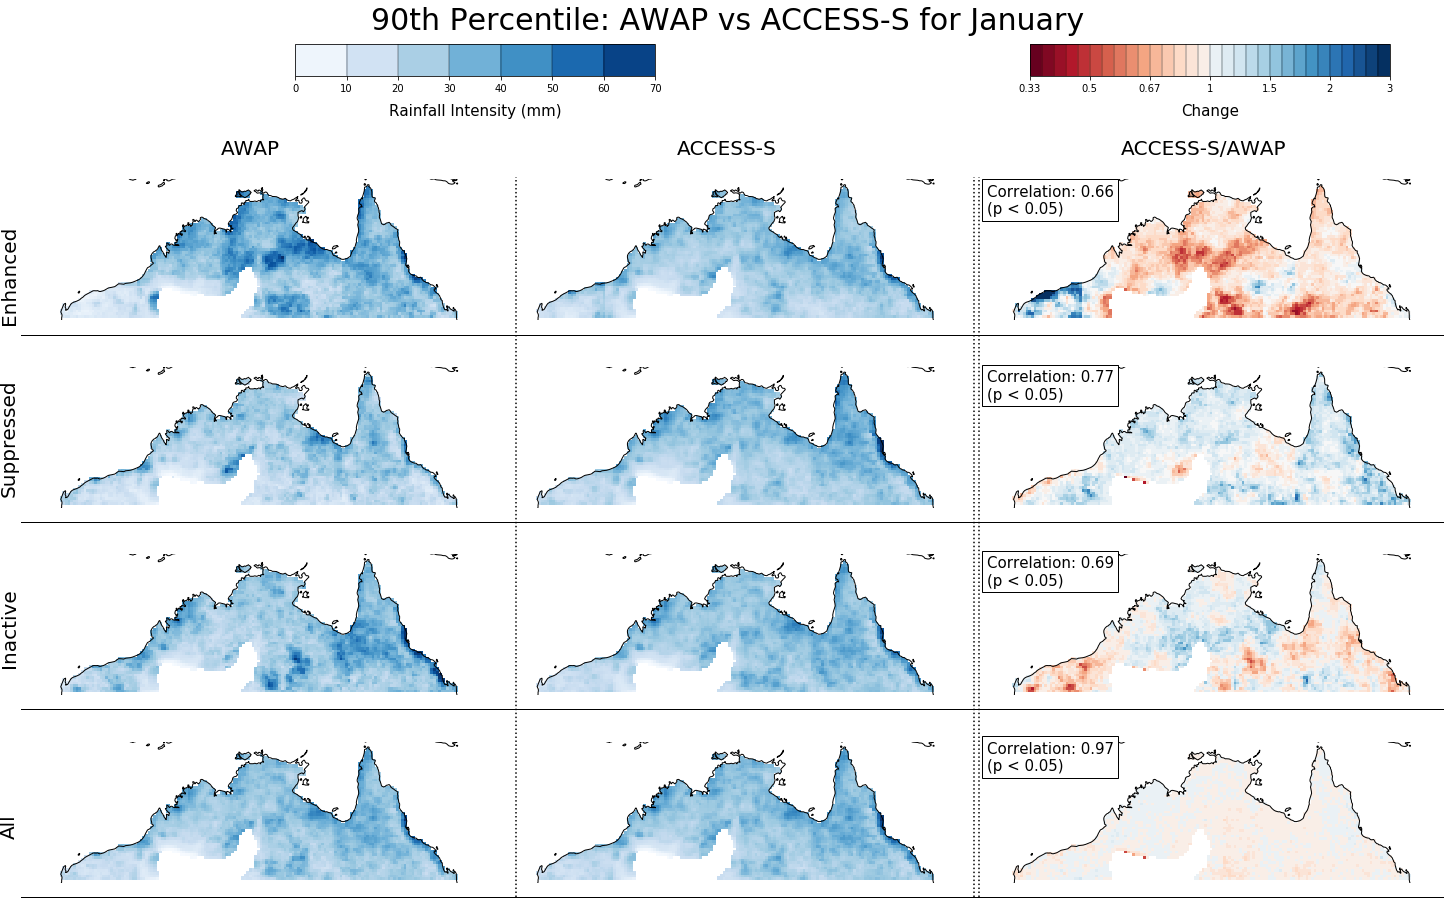

In [31]:

'''~~~~~~~~~ Plot'''
month = 1
save_directory = '/home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/'
rain_type = '90th Percentile'

comparison_plot(both_percentile_90, month, rain_type, save_directory,plot_max = 70, step = 10, save_fig = 0)

In [32]:
q = 90
months = [10,11,12,1,2,3]

for month in months:
    
    '''~~~~~~~~~ Calculation'''
    both_percentile= intensity_calculation_awap_access(aa, q = q, month = month)

    '''~~~~~~~~~ Plot'''
    save_directory = '/home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/'
    rain_type = '90th Percentile'

    comparison_plot(both_percentile, month, rain_type, save_directory,plot_max = 70, step = 10, save_fig = 1,
                   dont_plot = 1)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile: AWAP vs ACCESS-S for October" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile: AWAP vs ACCESS-S for November" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile: AWAP vs ACCESS-S for December" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile: AWAP vs ACCESS-S for January" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile: AWAP vs ACCESS-S for February" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile: AWAP vs ACCESS-S for March" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


<div class="alert alert-block alert-success"> <center> <font color = 'black' size = "+1.5"> Anomalies </font></center></div>

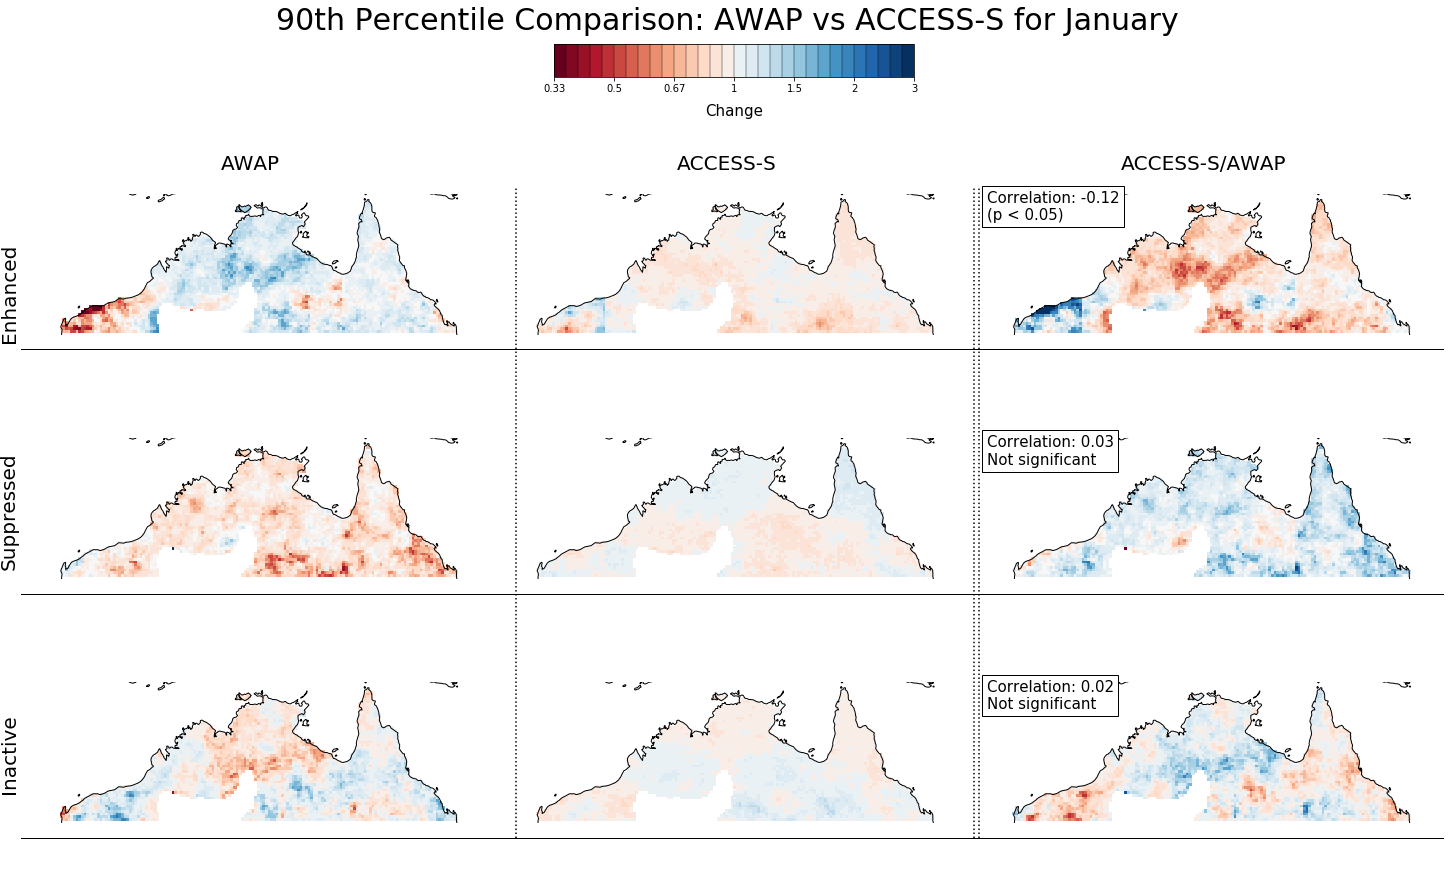

In [40]:

'''~~~~~~~~~ Plot'''
month = 1
rain_type = '90th Percentile Comparison'

comparison_plot_anomalies(anom_data, month, rain_type, save_directory, save_fig = 0)

Figure "  Inactive" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


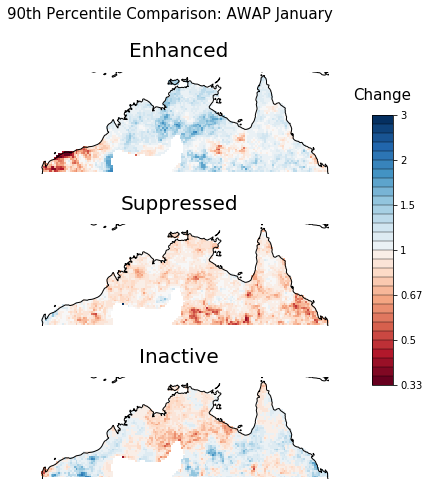

In [147]:

'''~~~~~~~~~ Plot'''
month = 1
rain_type = '90th Percentile Comparison'

comparison_plot_anomalies_single(anom_data.awap, month, rain_type, save_directory, title_piece = 'AWAP ',
                                 save_fig = 1)

In [33]:
q = 90
months = [10,11,12,1,2,3]

for month in months:
    
    '''~~~~~~~~~ Calculation'''
    both_percentile= intensity_calculation_awap_access(aa, q = q, month = month)
    
    anom_data = both_percentile

    anom_data = anom_data/ anom_data.sel(mjo = 'all')
    anom_data = anom_data.isel(mjo = slice(0,3))
    
    '''~~~~~~~~~ Plot'''
    save_directory = '/home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/'
    rain_type = '90th Percentile Comparison'

    comparison_plot_anomalies(anom_data, month, rain_type, save_directory, save_fig = 1, dont_plot = 1)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile Comparison: AWAP vs ACCESS-S for October" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile Comparison: AWAP vs ACCESS-S for November" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile Comparison: AWAP vs ACCESS-S for December" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile Comparison: AWAP vs ACCESS-S for January" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile Comparison: AWAP vs ACCESS-S for February" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/matplotlib/text.py:2098: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnin

Figure "  90th Percentile Comparison: AWAP vs ACCESS-S for March" has been saved to the directory /home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/


# Count

In [29]:
'''Need to generate a climatology'''
aa


<xarray.Dataset>
Dimensions:   (ensemble: 11, lat: 53, lon: 178, mjo: 4, time: 4192)
Coordinates:
  * time      (time) datetime64[ns] 1990-01-01T12:00:00 ... 2012-12-31T12:00:00
  * lat       (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -10.5 -10.25 -10.0
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
  * lon       (lon) float64 112.0 112.2 112.5 112.8 ... 155.5 155.8 156.0 156.2
  * mjo       (mjo) object 'enhanced' 'suppressed' 'inactive' 'all'
Data variables:
    access    (mjo, ensemble, time, lat, lon) float32 dask.array<chunksize=(1, 1, 4192, 53, 33), meta=np.ndarray>
    awap      (mjo, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

# Sums

In [ ]:

'''~~~~~~~~~ Calculation'''
aa_month = aa_mjo.where(aa_mjo.time.dt.month == month, drop = True) 
awap_sum = aa_month.awap.sum(dim = 'time').to_dataset(name = 'awap')
access_sum = aa_month.access.sum(dim = 'time').mean(dim = 'ensemble').to_dataset(name = 'access')

both_sum  = awap_sum.combine_first(access_sum)

In [ ]:

'''~~~~~~~~~ Plot'''
month = 1
save_directory = '/home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/'
rain_type = 'All Rainfall'

comparison_plot(both_sum, month, rain_type, save_directory,plot_max = 6000, save_fig = 0)

In [ ]:
from scipy.stats import spearmanr

In [ ]:
'''Creating Pattern Correlations'''



test = both_sum.sel(mjo = 'enhanced')
awap_t = np.array(test.awap.values).flatten()
access_t = np.array(test.access.values).flatten()



In [ ]:
correlation  = spearmanr(awap_t, access_t)
correlation

# Defunked

## Extreme Calculation

Sample calculation for January (month = 1)


In [ ]:
# This is just a dataset of the events that are above the extreme threshhold

access_mjo_90 = mjo_calc.return_monthly_extremes(access_mjo,90, months = [1])

In [ ]:
access_mjo_90.sel(ensemble = 1, mjo = 'enhanced').pr.sum(dim = 'time').plot()

In [ ]:
access_mjo_90

In [ ]:
access_90_count = access_mjo_90.sum(dim = ['time','ensemble']) # Summing across time and ensemble dims
access_90_count

In [ ]:
access_count = access_mjo.sum(dim = ['time','ensemble'])
access_count

In [ ]:
access_count_90_anomalies =  (access_90_count /access_count) / 0.1
access_count_90_anomalies

In [ ]:
access_count_90_anomalies.sel(mjo = 'enhanced').pr.plot()

## Single

In [ ]:
def custom_RdBu(vmax):
    import matplotlib.colors as pltc
    from pylab import cm
    from matplotlib.colors import BoundaryNorm


    vmin = 1/vmax

    l1 = np.array([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.2,2.4,2.6,2.8,3])
    l2 = 1/l1 # The decimal values are the inverse of these values
    l2 = np.flip(l2) # Need to order them in the right direction
    levels = np.concatenate((l2,np.array([1]),l1)) # Combining them all together and adding 1 into the middle
    levels = levels[np.where(np.logical_and(levels <= vmax, levels >= vmin))] # Only want the values in vmin
    # and vmax

    # Selecting a color bar that has the number of descrete levels as we have choesen above

    custom_RdBu = cm.get_cmap("RdBu",len(levels))(np.arange(len(levels)))

    # Turning this back into a color bar
    cmap_custom_RdBu = pltc.LinearSegmentedColormap.from_list("RdWtBu", custom_RdBu, len(levels))
    
    
    return cmap_custom_RdBu, levels
    

def difference_colorbar(fig, comp_plot,vmin, vmax):
    
    
    # x,y, width, height
    cax = fig.add_axes([1, 0.06, 0.03,0.2])
    
    
    # These are the range of different locatins for ticks that I want
    tick_labels = np.array([0.33334, 0.5, 0.666666666,1, 1.5 , 2, 3 ])

    # The string version
    tick_strings = np.array(['0.33', '0.5', '0.67','1', '1.5' , '2' , '3' ])
    
    # Finding the strings and labels in the range that I need
    tick_strings = tick_strings[np.where(np.logical_and(tick_labels <= vmax, tick_labels >= vmin))]
    tick_labels = tick_labels[np.where(np.logical_and(tick_labels <= vmax, tick_labels >= vmin))]
    
    # The actual plot
    cbar = plt.colorbar(comp_plot, cax = cax,orientation = 'vertical',drawedges = True, ticks = tick_labels)

    # Adding the strings as the tick labels
    cbar.ax.set_xticklabels(tick_strings) 
    cbar.set_label('Change', fontsize = 12, labelpad = 10)    
    

def normal_colorbar(fig, total_plot,plot_max):
    
    
    # x,y, width, height
    cax = fig.add_axes([1, 0.35,0.03,0.3])
    step =500
    ticks = np.arange(0, 6000 + step, step)
    
    

    cbar = plt.colorbar(total_plot, cax = cax,orientation = 'vertical',drawedges = True, 
                        boundaries = ticks,ticks = ticks)

    cbar.set_label('Rainfall (mm)', fontsize = 12, labelpad = 10)    

In [ ]:
def comparison_plot_count(aa, month, plot_max = 6000):
    vmax = 3
    vmin  = 1/vmax

    
    
    aa = aa.where(aa.time.dt.month == month, drop = True)
    
    

    fig = plt.figure(figsize = (8,15))
    
    '''~~~~~~~~~~~~~~~  AWAP'''
    ax = fig.add_subplot(3,1,1, projection  = ccrs.PlateCarree())
    awap = aa.awap.sum(dim = 'time')
    awap.plot(ax = ax,vmax = plot_max,cmap = 'Blues', add_colorbar = False)
    ax.set_title('AWAP')
    ax.coastlines(resolution = '50m')
    
    '''~~~~~~~~~~~~~~~  ACCESS-S'''
    ax = fig.add_subplot(3,1,2, projection = ccrs.PlateCarree())
    access = aa.access.sum(dim = 'time').mean(dim = 'ensemble')
    total_plot = access.plot(ax = ax,vmax = plot_max, cmap = 'Blues', add_colorbar = False)
    ax.set_title('ACCESS-S')
    ax.coastlines(resolution = '50m')
    
    normal_colorbar(fig, total_plot,plot_max)
    
    
    
    '''~~~~~~~~~~~~~~~  ACCESS-S/ AWAP'''
    '''This needs a custom cololr bar'''
    cmap_custom_RdBu, levels = custom_RdBu(vmax) 
    
    
    
    comparison = access/ awap
    
    ax = fig.add_subplot(3,1,3, projection = ccrs.PlateCarree())
    comp_plot = comparison.plot(ax = ax, cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                    norm = BoundaryNorm(levels, len(levels)-1))
    ax.set_title('ACCESS-S/AWAP')
    ax.coastlines(resolution = '50m')
    
    difference_colorbar(fig, comp_plot,vmin, vmax)
    
    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.8])

In [ ]:
comparison_plot_count(aa_mjo.sel( mjo  = 'enhanced'),  1, plot_max = 6000)

## Multiple

In [ ]:
def custom_RdBu(vmax):
    import matplotlib.colors as pltc
    from pylab import cm
    from matplotlib.colors import BoundaryNorm


    vmin = 1/vmax

    l1 = np.array([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.2,2.4,2.6,2.8,3])
    l2 = 1/l1 # The decimal values are the inverse of these values
    l2 = np.flip(l2) # Need to order them in the right direction
    levels = np.concatenate((l2,np.array([1]),l1)) # Combining them all together and adding 1 into the middle
    levels = levels[np.where(np.logical_and(levels <= vmax, levels >= vmin))] # Only want the values in vmin
    # and vmax

    # Selecting a color bar that has the number of descrete levels as we have choesen above

    custom_RdBu = cm.get_cmap("RdBu",len(levels))(np.arange(len(levels)))

    # Turning this back into a color bar
    cmap_custom_RdBu = pltc.LinearSegmentedColormap.from_list("RdWtBu", custom_RdBu, len(levels))
    
    
    return cmap_custom_RdBu, levels
    

def difference_colorbar_horizontal(fig, comp_plot,vmin, vmax):
    
    
    # x,y, width, height
    cax = fig.add_axes([0.65, 0.8,0.3,0.03])
    
    
    # These are the range of different locatins for ticks that I want
    tick_labels = np.array([0.33334, 0.5, 0.666666666,1, 1.5 , 2, 3 ])

    # The string version
    tick_strings = np.array(['0.33', '0.5', '0.67','1', '1.5' , '2' , '3', ])
    
    # Finding the strings and labels in the range that I need
    tick_strings = tick_strings[np.where(np.logical_and(tick_labels <= vmax, tick_labels >= vmin))]
    tick_labels = tick_labels[np.where(np.logical_and(tick_labels <= vmax, tick_labels >= vmin))]
    
    # The actual plot
    cbar = plt.colorbar(comp_plot, cax = cax,orientation = 'horizontal',drawedges = True, ticks = tick_labels)

    # Adding the strings as the tick labels
    cbar.ax.set_xticklabels(tick_strings) 
    cbar.set_label('Change', fontsize = 12, labelpad = 10)    
    

def normal_colorbar_horizontal(fig, total_plot,plot_max):
    
    
    # x,y, width, height
    cax = fig.add_axes([0.2, 0.8,0.3,0.03])
    step = 500
    ticks = np.arange(0, 6000 + step, step)
    
    

    cbar = plt.colorbar(total_plot, cax = cax,orientation = 'horizontal',drawedges = True, 
                        boundaries = ticks,ticks = ticks)

    cbar.set_label('Rainfall (mm)', fontsize = 12, labelpad = 10)    

In [ ]:
def comparison_plot_sum_all(aa, month, rain_type, save_directory,plot_max = 6000, save_fig = 0):
    vmax = 3
    vmin  = 1/vmax

    
    
    
    
    aa = aa.where(aa.time.dt.month == month, drop = True)
    
    

    fig = plt.figure(figsize = (20,15),)
    title = rain_type + ': AWAP vs ACCESS-S for ' + dt.date(2015, int(month),1).strftime('%B')
    plt.suptitle(title, fontsize = 30,  y = 0.9)
    
    
    
    phases = aa_mjo.mjo.values
    num_rows = len(phases)
    
    plot_num = 1
    
    for phase in phases:
        
        data = aa.sel(mjo = phase)
    
        '''~~~~~~~~~~~~~~~  AWAP'''
        ax = fig.add_subplot(num_rows, 3 , plot_num, projection  = ccrs.PlateCarree())
        awap = data.awap.sum(dim = 'time')
        awap.plot(ax = ax,vmax = plot_max,cmap = 'Blues', add_colorbar = False)
     
        ax.coastlines(resolution = '50m')
        
        
        if plot_num <= 3:
            ax.set_title('AWAP')
        else:
            ax.set_title('')
            
        
        plot_num += 1

        '''~~~~~~~~~~~~~~~  ACCESS-S'''
        ax = fig.add_subplot(num_rows, 3 , plot_num, projection = ccrs.PlateCarree())
        access = data.access.sum(dim = 'time').mean(dim = 'ensemble')
        total_plot = access.plot(ax = ax,vmax = plot_max, cmap = 'Blues', add_colorbar = False)
        if plot_num <= 3:
            ax.set_title('ACCESS-S')
            
        else:
            ax.set_title('')
            
        ax.coastlines(resolution = '50m')
        
        
        plot_num += 1

        '''~~~~~~~~~~~~~~~  ACCESS-S/AWAP'''
        '''This needs a custom cololr bar'''
        cmap_custom_RdBu, levels = custom_RdBu(vmax) 
        ax = fig.add_subplot(num_rows, 3 ,plot_num, projection = ccrs.PlateCarree())
        comparison = access/ awap
        comp_plot = comparison.plot(ax = ax, cmap = cmap_custom_RdBu,vmin = vmin, vmax = vmax, add_colorbar = False,
                        norm = BoundaryNorm(levels, len(levels)-1))
        
        if plot_num <= 3:
            ax.set_title('ACCESS-S/AWAP')
        else:
            ax.set_title('')
            
        ax.coastlines(resolution = '50m')
    
    
        plot_num += 1
    
    
    
    
    
    '''~~~~~~~~~~~~~~~  Colorbars'''
    normal_colorbar_horizontal(fig, total_plot,plot_max)
    difference_colorbar_horizontal(fig, comp_plot,vmin, vmax)
    
    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.8])
    
    if save_fig:
        fig.savefig(save_directory + title + '.png',bbox_inches = 'tight', dpi = 300)
        print('Figure \" " ' + title + '\" has been saved to the directory '+ save_directory)
    

In [ ]:
month = 1
save_directory = '/home/563/ab2313/MJO/ACCESS/Plots/Rain Comparisons/'


rain_type = 'All Rainfall'
comparison_plot_sum_all(aa_mjo,  month,rain_type, save_directory,plot_max = 6000, save_fig = 1)